In [70]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
from sklearn.model_selection import cross_val_score


%matplotlib inline

In [71]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100# абсолютное значение

In [72]:
data = pd.read_csv('currency.csv', index_col=['Time'], parse_dates=['Time'])
#data = pd.read_csv('ik03_z.csv', index_col=['Time'], parse_dates=['Time'])
#data = pd.read_csv('iat1.csv', index_col=['Time'], parse_dates=['Time'])
#data = pd.read_csv('ads.csv', index_col=['Time'], parse_dates=['Time'])
data.columns = ["y"]

In [73]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [74]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
# Добавляет лаги сдвигает y на сколько глубоко мы захотим
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    data.index = pd.to_datetime(data.index)
    #data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика
    #                               сред                          
#    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
    #print(list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday)))
#    data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

    # выкидываем закодированные средними признаки 
    data.drop(["hour", "weekday","is_weekend"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

In [75]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [76]:
X_train, X_test, y_train, y_test = prepareData(data, test_size=0.3, lag_start=1, lag_end=2)
y_train.head(5)
#X_test.head(5)

0    1045515
1     586111
2     856601
3     793775
4     606535
Name: y, dtype: int64

In [77]:
tscv = TimeSeriesSplit(n_splits=5)

In [78]:
%%time
performTimeSeriesCV(X_train, y_train, 5, lr, mean_absolute_error)

Size train set: (211, 1)
Size of each fold: 42

Splitting the first 2 chunks at 1/2
Size of train + test: (84, 1)

Splitting the first 3 chunks at 2/3
Size of train + test: (126, 1)

Splitting the first 4 chunks at 3/4
Size of train + test: (168, 1)

Splitting the first 5 chunks at 4/5
Size of train + test: (210, 1)
Wall time: 975 ms


267086.4827594363

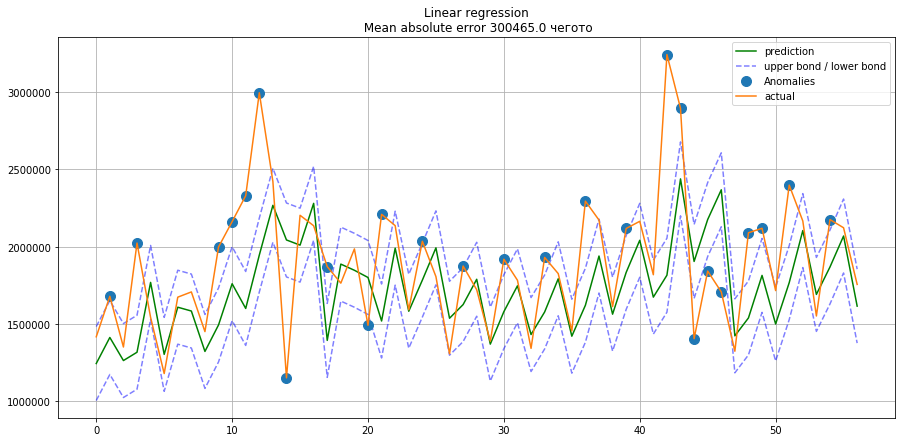

In [79]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(data, test_size=0.2, lag_start=1, lag_end=4)
lr = LinearRegression()
lr.fit(X_train, y_train)

# Доверительный интервал 
prediction = lr.predict(X_test)
cv = cross_val_score(lr, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
mae = cv.mean() * (-1)
deviation = cv.std()

scale = 1.96
lower = prediction - (mae + scale * deviation)
upper = prediction + (mae + scale * deviation)


prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "g", label="prediction")
plt.plot(lower, "b--", label="upper bond / lower bond", alpha=0.5)
plt.plot(upper, "b--", alpha=0.5)
anomalies = np.array([np.NaN]*len(y_test))
anomalies[y_test<lower] = y_test[y_test<lower]
anomalies[y_test>upper] = y_test[y_test>upper]
plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} чегото".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

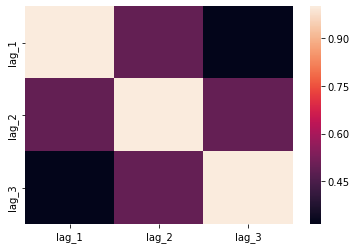

In [80]:
sns.heatmap(X_train.corr())

In [81]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

In [82]:
tscv = TimeSeriesSplit(n_splits=5)
ridge = RidgeCV(alphas =(1,1000,100), cv = tscv )
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.fit_transform(X_test)

In [83]:
ridge.fit(x_train_scaled, y_train)

RidgeCV(alphas=array([   1, 1000,  100]),
        cv=TimeSeriesSplit(max_train_size=None, n_splits=5), fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [84]:
ridge.alpha_

1

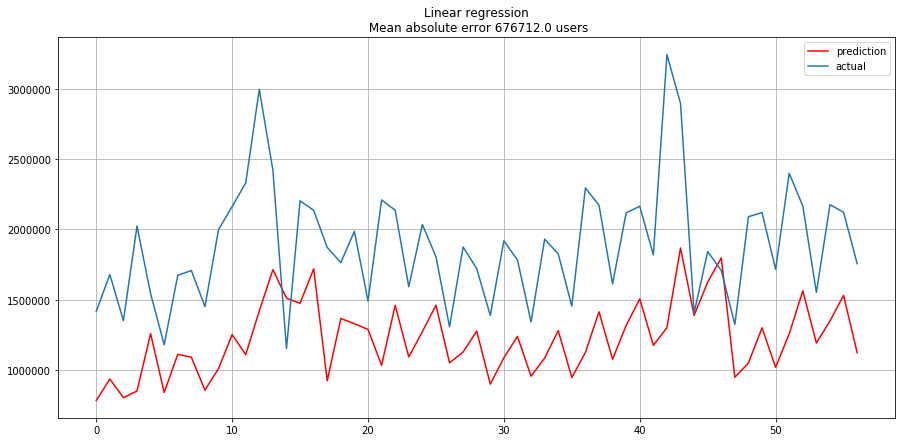

In [85]:
prediction = ridge.predict(x_test_scaled)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [86]:
import xgboost as xgb

def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(data, lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

[11:37:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:37:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:37:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:37:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:37:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:37:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:37:52] WARNI

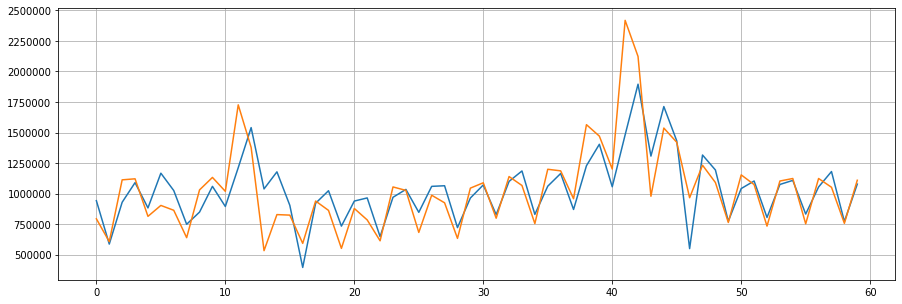

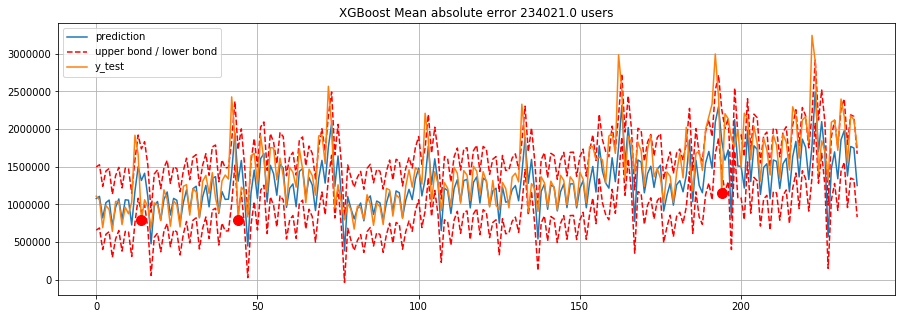

In [69]:
XGB_forecast(data, test_size=0.8, lag_start=1, lag_end=5)